# Autoencoders

An autoencoder takes an image as input, stores it in a lower dimension, and tries to
reproduce the same image as output, hence the term auto (which stands for being
able to reproduce the input). However, if we just reproduce the input in the output,
we would not need a network, but a simple multiplication of the input by 1 would do.
The differentiating aspect of an autoencoder is that it encodes the information present
in an image in a lower dimension and then reproduces the image, hence the term
encoder (which stands for representing the information of an image in a lower
dimension). This way, images that are similar will have similar encoding. Further, the
decoder works towards reconstructing the original image from the encoded vector.

![image](./imgs/auto1.png)

Let's say the input image is a flattened version of the MNIST handwritten digits and
the output image is the same as what is provided as input. The middlemost layer is
the layer of encoding called the bottleneck layer. The operations happening between
the input and the bottleneck layer represent the encoder and the operations between
the bottleneck layer and output represent the decoder.

Through the bottleneck layer, we can represent an image in a much
lower dimension. Furthermore, with the bottleneck layer, we can
reconstruct the original image. We leverage the bottleneck layer to
solve the problems of identifying similar images as well as
generating new images, which we will learn how to do in
subsequent sections.


The bottleneck layer helps in the following ways:
- Images that have similar bottleneck layer values (encoded representations)
are likely to be similar to each other.
- By changing the node values of the bottleneck layer, we can change the
output image.

With the preceding understanding, let's do the following:
- Implement autoencoders from scratch
- Visualize the similarity of images based on bottleneck layer values

## Implementing vanilla autoencoders

In [2]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [4]:
ROOT_DATA = "~/Data"

In [6]:
trn_ds = MNIST('~/Data/mnist/', transform=img_transform, train=True, download=True)
val_ds = MNIST('~/Data/mnist/', transform=img_transform, train=False, download=True)

In [7]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True), 
            #nn.Linear(64, 12),  nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True), 
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [9]:
!pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [10]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000  val_loss: 0.197  trn_loss: 0.266  (3.86s - 15.42s remaining)
EPOCH: 2.000  val_loss: 0.174  trn_loss: 0.185  (7.72s - 11.58s remaining)
EPOCH: 3.000  val_loss: 0.161  trn_loss: 0.167  (11.53s - 7.68s remaining)
EPOCH: 4.000  val_loss: 0.154  trn_loss: 0.158  (15.44s - 3.86s remaining)
EPOCH: 5.000  val_loss: 0.151  trn_loss: 0.153  (19.32s - 0.00s remaining)


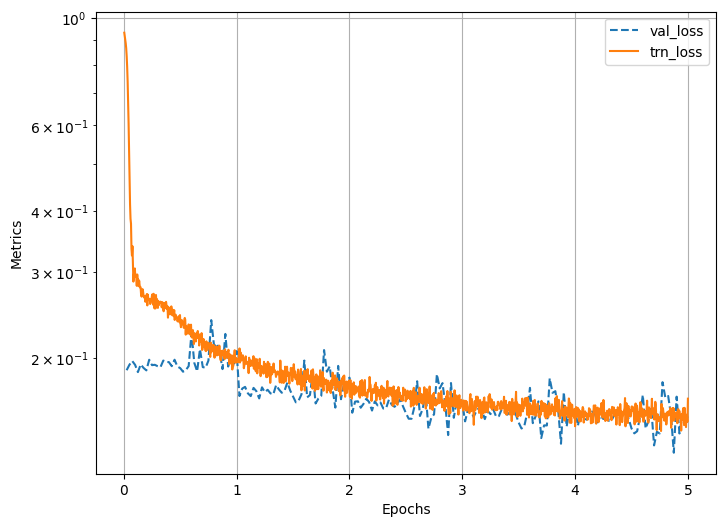

In [11]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

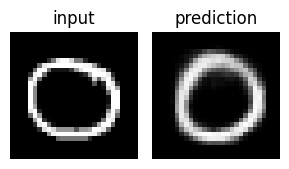

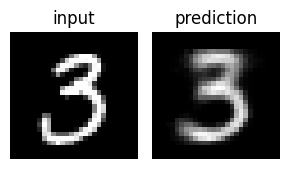

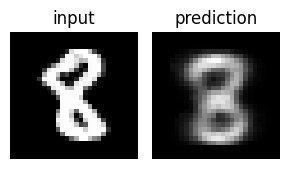

In [12]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3)) 
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

EPOCH: 1.000  val_loss: 0.128  trn_loss: 0.235  (3.88s - 15.51s remaining)
EPOCH: 2.000  val_loss: 0.092  trn_loss: 0.109  (7.83s - 11.74s remaining)
EPOCH: 3.000  val_loss: 0.076  trn_loss: 0.085  (11.75s - 7.83s remaining)
EPOCH: 4.000  val_loss: 0.070  trn_loss: 0.075  (15.65s - 3.91s remaining)
EPOCH: 5.000  val_loss: 0.066  trn_loss: 0.069  (19.61s - 0.00s remaining)


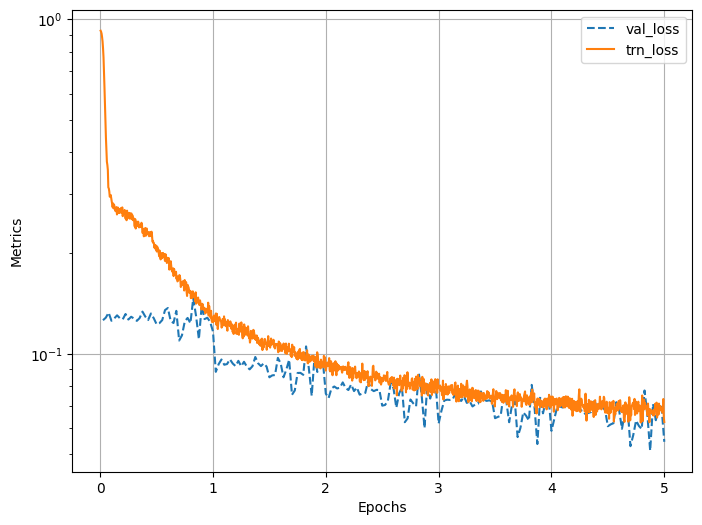

EPOCH: 1.000  val_loss: 0.208  trn_loss: 0.260  (4.07s - 16.26s remaining)
EPOCH: 2.000  val_loss: 0.190  trn_loss: 0.199  (8.02s - 12.03s remaining)
EPOCH: 3.000  val_loss: 0.182  trn_loss: 0.185  (12.00s - 8.00s remaining)
EPOCH: 4.000  val_loss: 0.176  trn_loss: 0.178  (16.04s - 4.01s remaining)
EPOCH: 5.000  val_loss: 0.173  trn_loss: 0.174  (20.05s - 0.00s remaining)


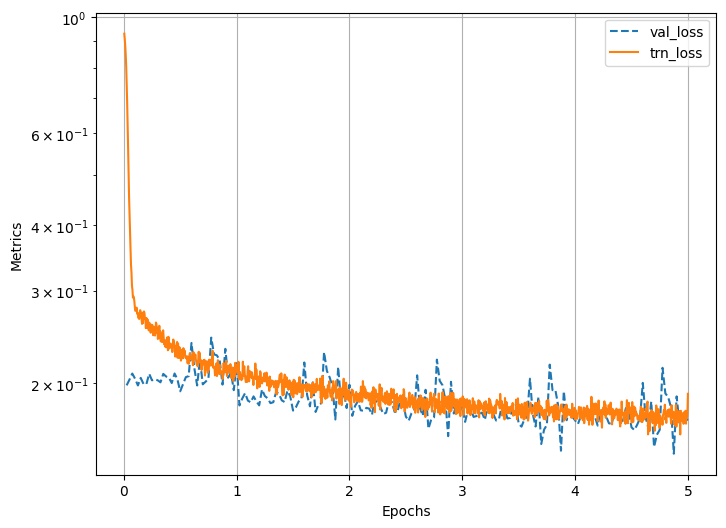

EPOCH: 1.000  val_loss: 0.189  trn_loss: 0.260  (4.01s - 16.05s remaining)
EPOCH: 2.000  val_loss: 0.164  trn_loss: 0.173  (8.04s - 12.07s remaining)
EPOCH: 3.000  val_loss: 0.156  trn_loss: 0.159  (12.14s - 8.09s remaining)
EPOCH: 4.000  val_loss: 0.151  trn_loss: 0.153  (16.30s - 4.07s remaining)
EPOCH: 5.000  val_loss: 0.147  trn_loss: 0.149  (20.37s - 0.00s remaining)


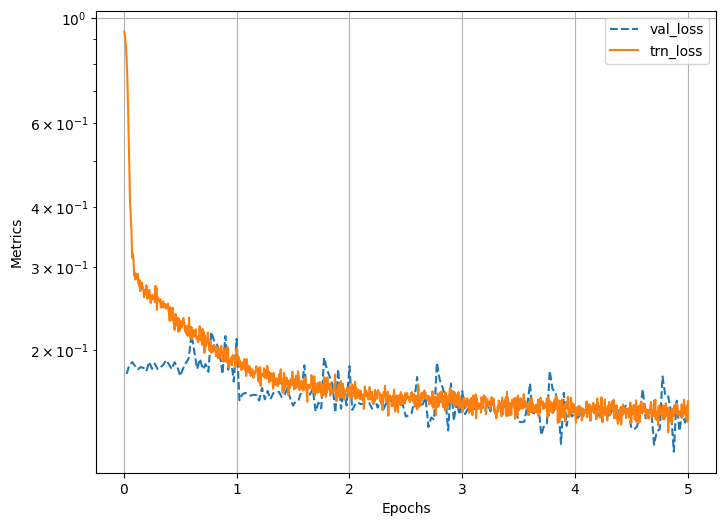

EPOCH: 1.000  val_loss: 0.169  trn_loss: 0.257  (4.34s - 17.37s remaining)
EPOCH: 2.000  val_loss: 0.141  trn_loss: 0.153  (8.61s - 12.91s remaining)
EPOCH: 3.000  val_loss: 0.129  trn_loss: 0.135  (12.80s - 8.53s remaining)
EPOCH: 4.000  val_loss: 0.124  trn_loss: 0.126  (16.93s - 4.23s remaining)
EPOCH: 5.000  val_loss: 0.120  trn_loss: 0.122  (21.14s - 0.00s remaining)


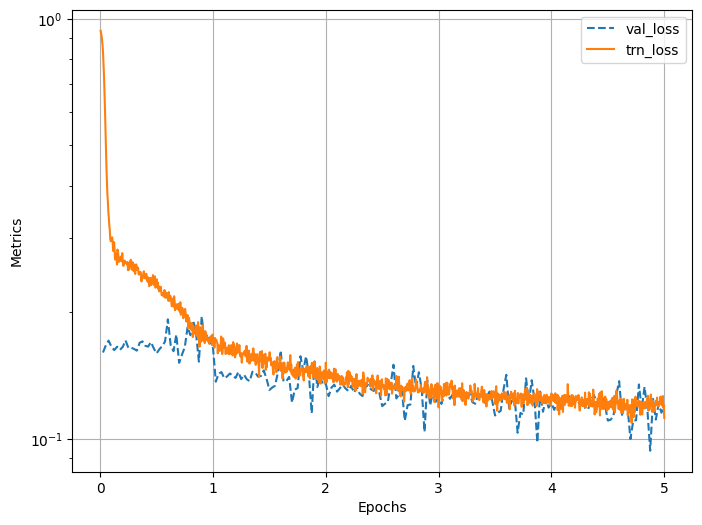

EPOCH: 1.000  val_loss: 0.143  trn_loss: 0.234  (4.14s - 16.57s remaining)
EPOCH: 2.000  val_loss: 0.116  trn_loss: 0.127  (8.40s - 12.60s remaining)
EPOCH: 3.000  val_loss: 0.101  trn_loss: 0.108  (12.62s - 8.41s remaining)
EPOCH: 4.000  val_loss: 0.096  trn_loss: 0.099  (16.77s - 4.19s remaining)
EPOCH: 5.000  val_loss: 0.090  trn_loss: 0.094  (20.94s - 0.00s remaining)


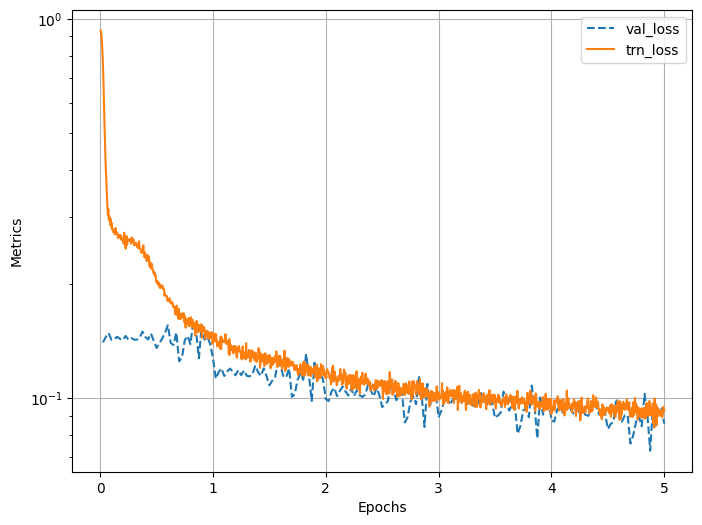

In [13]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

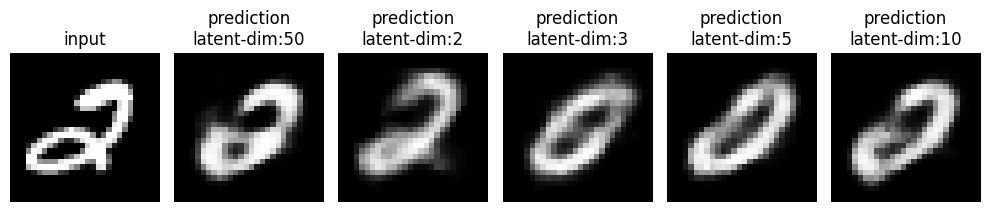

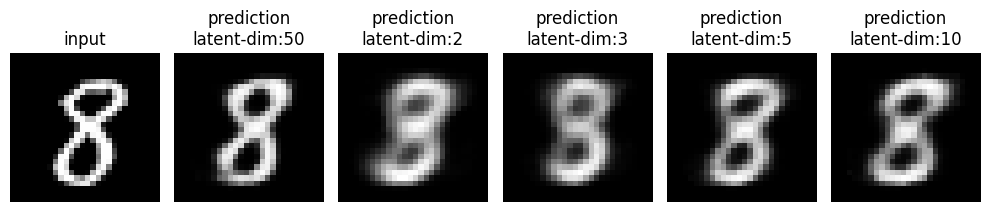

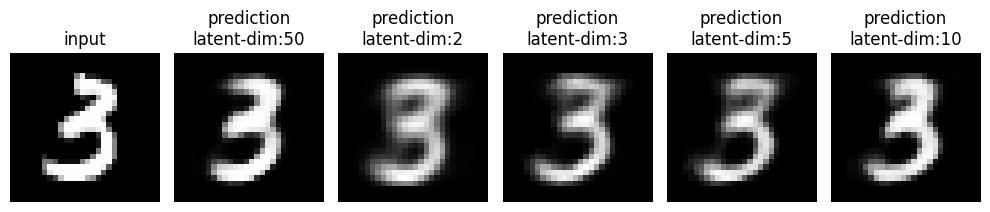

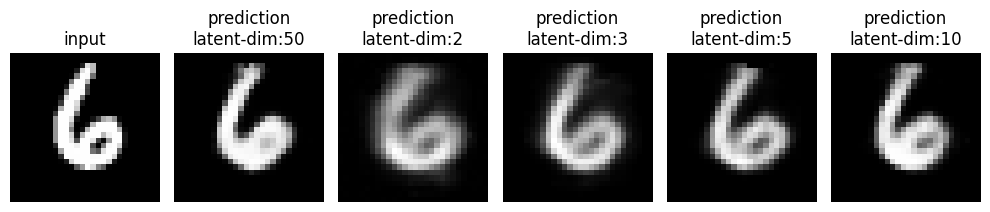

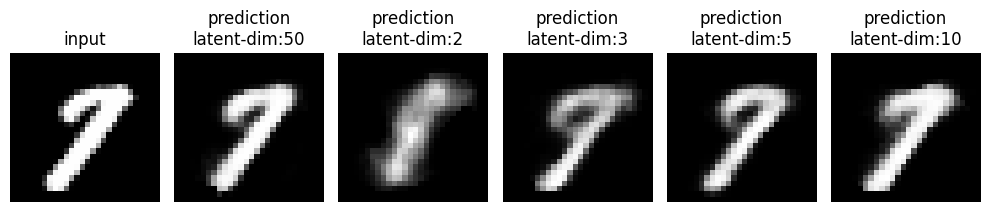

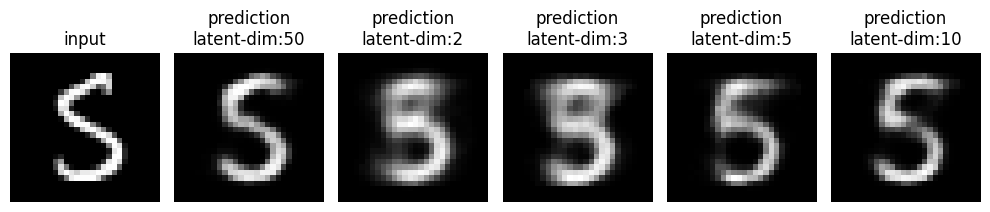

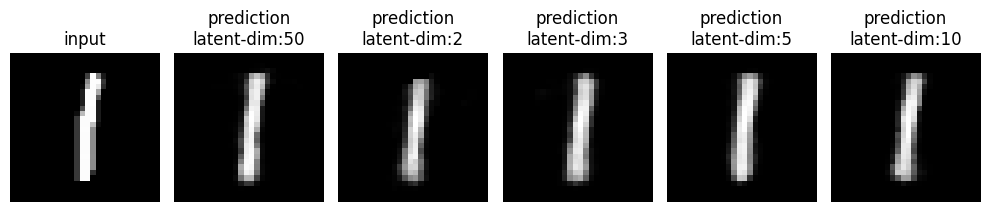

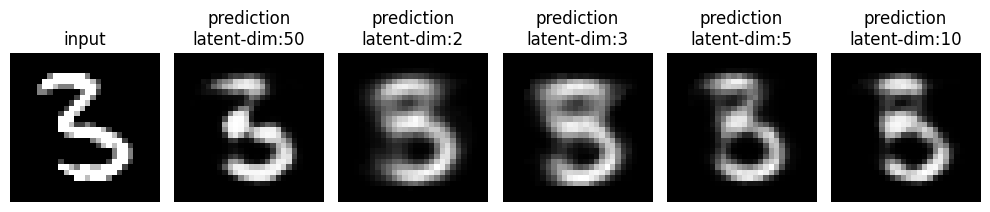

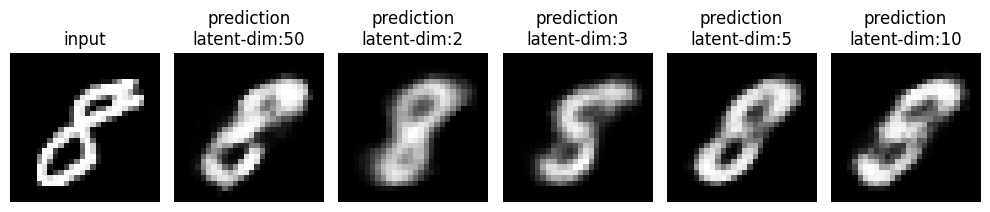

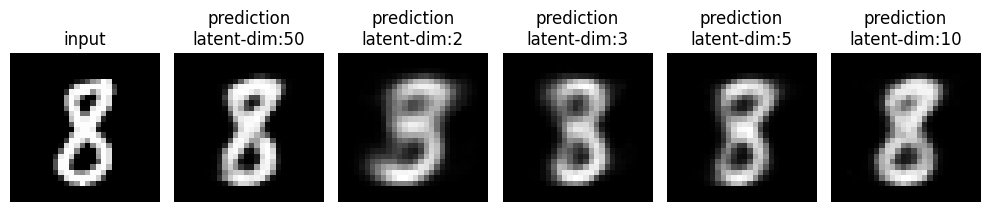

In [14]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()